<a href="https://colab.research.google.com/github/JunjieLeiCoe/.dotfiles/blob/main/ECS271_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # For progress bars in Colab
import cv2 # For FFT/IFFT operations (OpenCV is often pre-installed or easily installed)
import os
from torchvision.datasets import CIFAR10
from PIL import Image
import math

In [ ]:
# Set a random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# --- Configuration ---
BATCH_SIZE = 128
NUM_EPOCHS = 50 # Reduced for demonstration, you'll likely want more [cite: 70]
LEARNING_RATE = 0.001
DATA_ROOT = './data'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
class CIFAR10FrequencyDataset(CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False, cutoff_percentage=1.0):
        super().__init__(root, train=train, transform=transform, download=download)
        self.cutoff_percentage = cutoff_percentage

    def set_cutoff_percentage(self, pct: float):
        if not (0.0 <= pct <= 1.0):
            print("Warning: cutoff_percentage should be between 0.0 and 1.0. Clamping value.")
            self.cutoff_percentage = max(0.0, min(1.0, pct))
        else:
            self.cutoff_percentage = pct

    def __getitem__(self, index):
        img_np = self.data[index]
        target = self.targets[index]

        img_pil_original = Image.fromarray(np.uint8(img_np))

        if self.cutoff_percentage >= 1.0:
            if self.transform is not None:
                return self.transform(img_pil_original), target
            else:
                return img_pil_original, target

        img_float = np.float32(img_np) / 255.0

        processed_channels = []
        for i in range(3): # For R, G, B channels
            channel = img_float[:, :, i]

            # --- USING NUMPY'S FFT FUNCTIONS FOR COMPLEX NUMBERS ---
            # Perform 2D DFT using numpy
            # The output is directly a complex-valued array
            dft = np.fft.fft2(channel)
            # Shift the zero-frequency component to the center
            fshift = np.fft.fftshift(dft)

            rows, cols = channel.shape
            crow, ccol = rows // 2, cols // 2 # Center of the spectrum

            # Create a circular mask for low-pass filtering
            # The radius calculation remains the same
            radius = math.ceil(min(crow, ccol) * self.cutoff_percentage)

            # Create a single-channel mask of boolean type or float32
            # This mask will be applied directly to the complex spectrum
            mask = np.zeros((rows, cols), np.uint8) # Use uint8 for drawing circle
            cv2.circle(mask, (ccol, crow), radius, 1, -1)
            # Convert mask to boolean or float for element-wise multiplication
            mask_float = mask.astype(np.float32)

            # Apply the mask directly to the complex spectrum
            # This multiplies both real and imaginary parts by the mask value
            fshift_filtered = fshift * mask_float

            # Inverse Shift
            f_ishift = np.fft.ifftshift(fshift_filtered)

            # Inverse DFT using numpy
            # np.fft.ifft2 returns a complex array, we take the real part
            img_back = np.fft.ifft2(f_ishift)
            # Take the absolute value of the real part, as sometimes small negative
            # values can appear due to floating point inaccuracies.
            # Then normalize to 0-1 range using cv2.normalize
            processed_channel = cv2.normalize(np.abs(img_back.real), None, 0.0, 1.0, cv2.NORM_MINMAX)
            # --- END NUMPY'S FFT FUNCTIONS ---

            processed_channels.append(processed_channel)

        img_processed_color = np.stack(processed_channels, axis=-1)

        img_pil = Image.fromarray(np.uint8(img_processed_color * 255.0))

        if self.transform is not None:
            img_pil = self.transform(img_pil)

        return img_pil, target

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Your custom curriculum dataset with initial cutoff
print("Loading CIFAR-10 frequency-filtered dataset...")
initial_cutoff = 0.05
train_dataset_curriculum = CIFAR10FrequencyDataset(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform_train,
    cutoff_percentage=initial_cutoff
)

train_loader_curriculum = DataLoader(
    train_dataset_curriculum,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Standard CIFAR-10 for baseline
train_dataset_baseline = datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform_train
)
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("CIFAR-10 dataset loaded.")

Loading CIFAR-10 frequency-filtered dataset...
CIFAR-10 dataset loaded.


In [ ]:
# --- 3. Model Definition (ResNet-18) ---
# We'll use a pre-trained ResNet-18 model and adjust its final layer for CIFAR-10
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 classes for CIFAR-10
model = model.to(DEVICE)

In [ ]:
# --- 4. Training Function ---
def train_model(model, train_loader, test_loader, num_epochs, optimizer, criterion, scheduler=None, is_curriculum=False, dataset_obj=None):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"\n--- Starting Training ({'Curriculum' if is_curriculum else 'Baseline'}) ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        if is_curriculum:
            new_cutoff = min(1.0, 0.01 + 0.99 * (epoch / num_epochs))
            dataset_obj.set_cutoff_percentage(new_cutoff)
            print(f"Epoch {epoch+1}: cutoff set to {new_cutoff:.3f}")

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        if scheduler:
            scheduler.step()

    print(f"--- Training Complete ({'Curriculum' if is_curriculum else 'Baseline'}) ---")
    return history


--- Visualizing Frequency-Limited Images at Different Epochs ---


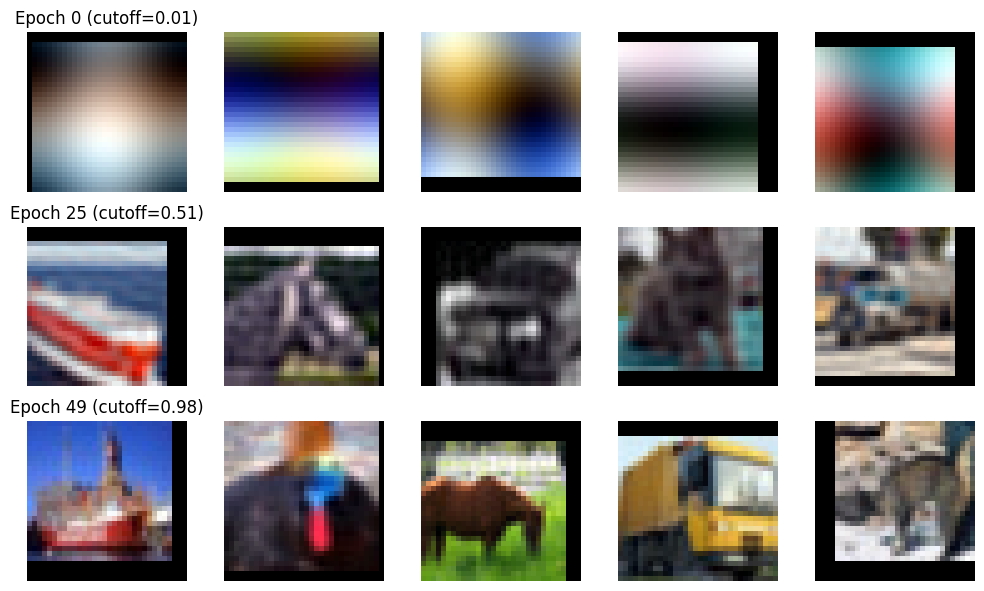

In [ ]:
print("\n--- Visualizing Frequency-Limited Images at Different Epochs ---")

def visualize_frequency_cutoff(dataset_obj, epochs_to_show, num_images_per_epoch=5):
    fig, axes = plt.subplots(len(epochs_to_show), num_images_per_epoch, figsize=(num_images_per_epoch * 2, len(epochs_to_show) * 2))

    inv_normalize = transforms.Normalize(
        mean=(-0.4914 / 0.2023, -0.4822 / 0.1994, -0.4465 / 0.2010),
        std=(1 / 0.2023, 1 / 0.1994, 1 / 0.2010)
    )

    for i, epoch in enumerate(epochs_to_show):
        cutoff = min(1.0, 0.01 + 0.99 * (epoch / NUM_EPOCHS))
        dataset_obj.set_cutoff_percentage(cutoff)

        temp_loader = DataLoader(dataset_obj, batch_size=num_images_per_epoch, shuffle=True, num_workers=0)
        images, _ = next(iter(temp_loader))

        for j in range(num_images_per_epoch):
            img = images[j].cpu()
            img = inv_normalize(img)
            img = np.transpose(img.numpy(), (1, 2, 0))
            img = np.clip(img, 0, 1)

            ax = axes[i, j] if len(epochs_to_show) > 1 else axes[j]
            ax.imshow(img)
            if j == 0:
                ax.set_title(f'Epoch {epoch} (cutoff={cutoff:.2f})')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize at 3 curriculum stages: beginning, middle, end
epochs_to_visualize = [0, NUM_EPOCHS // 2, NUM_EPOCHS - 1]
visualize_frequency_cutoff(train_dataset_curriculum, epochs_to_visualize)


In [ ]:
# --- 5. Training Setup and Execution ---
criterion = nn.CrossEntropyLoss()

# --- Run Baseline Training ---
print("\n--- Training Baseline ResNet-18 ---")
model_baseline = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_baseline.fc.in_features
model_baseline.fc = nn.Linear(num_ftrs, 10)
model_baseline = model_baseline.to(DEVICE)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)
scheduler_baseline = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_baseline, T_max=NUM_EPOCHS)

history_baseline = train_model(model_baseline, train_loader_baseline, test_loader,
                               NUM_EPOCHS, optimizer_baseline, criterion, scheduler_baseline,
                               is_curriculum=False)




--- Training Baseline ResNet-18 ---

--- Starting Training (Baseline) ---


Epoch 1/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 1.0211 Acc: 0.6467 | Val Loss: 0.7770 Acc: 0.7375


Epoch 2/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 0.7308 Acc: 0.7497 | Val Loss: 0.7449 Acc: 0.7489


Epoch 3/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 0.6429 Acc: 0.7797 | Val Loss: 0.5973 Acc: 0.7977


Epoch 4/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 0.5940 Acc: 0.7961 | Val Loss: 0.5604 Acc: 0.8081


Epoch 5/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 0.5642 Acc: 0.8065 | Val Loss: 0.6054 Acc: 0.7952


Epoch 6/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 0.5134 Acc: 0.8228 | Val Loss: 0.5661 Acc: 0.8074


Epoch 7/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.4864 Acc: 0.8323 | Val Loss: 0.5201 Acc: 0.8239


Epoch 8/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.4594 Acc: 0.8429 | Val Loss: 0.4846 Acc: 0.8348


Epoch 9/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.4358 Acc: 0.8486 | Val Loss: 0.4810 Acc: 0.8352


Epoch 10/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.4209 Acc: 0.8573 | Val Loss: 0.4992 Acc: 0.8349


Epoch 11/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.4024 Acc: 0.8615 | Val Loss: 0.5090 Acc: 0.8295


Epoch 12/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.3853 Acc: 0.8675 | Val Loss: 0.5658 Acc: 0.8169


Epoch 13/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.5226 Acc: 0.8228 | Val Loss: 0.4764 Acc: 0.8426


Epoch 14/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.3809 Acc: 0.8684 | Val Loss: 0.4576 Acc: 0.8477


Epoch 15/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.3430 Acc: 0.8817 | Val Loss: 0.4461 Acc: 0.8522


Epoch 16/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.3231 Acc: 0.8866 | Val Loss: 0.4560 Acc: 0.8519


Epoch 17/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.3140 Acc: 0.8905 | Val Loss: 0.4547 Acc: 0.8563


Epoch 18/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.2977 Acc: 0.8944 | Val Loss: 0.4351 Acc: 0.8570


Epoch 19/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.2843 Acc: 0.9013 | Val Loss: 0.4503 Acc: 0.8574


Epoch 20/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.2720 Acc: 0.9046 | Val Loss: 0.4611 Acc: 0.8571


Epoch 21/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.2559 Acc: 0.9104 | Val Loss: 0.4479 Acc: 0.8577


Epoch 22/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.2448 Acc: 0.9135 | Val Loss: 0.4477 Acc: 0.8601


Epoch 23/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.2384 Acc: 0.9160 | Val Loss: 0.4641 Acc: 0.8573


Epoch 24/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.2231 Acc: 0.9208 | Val Loss: 0.4493 Acc: 0.8626


Epoch 25/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.2130 Acc: 0.9253 | Val Loss: 0.4414 Acc: 0.8615


Epoch 26/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.1994 Acc: 0.9303 | Val Loss: 0.4290 Acc: 0.8688


Epoch 27/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.1863 Acc: 0.9333 | Val Loss: 0.4355 Acc: 0.8691


Epoch 28/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.1783 Acc: 0.9364 | Val Loss: 0.4602 Acc: 0.8670


Epoch 29/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.1686 Acc: 0.9402 | Val Loss: 0.4438 Acc: 0.8691


Epoch 30/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.1568 Acc: 0.9444 | Val Loss: 0.4548 Acc: 0.8683


Epoch 31/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.1460 Acc: 0.9486 | Val Loss: 0.4697 Acc: 0.8681


Epoch 32/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.1350 Acc: 0.9520 | Val Loss: 0.4660 Acc: 0.8697


Epoch 33/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.1281 Acc: 0.9543 | Val Loss: 0.4709 Acc: 0.8702


Epoch 34/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.1199 Acc: 0.9567 | Val Loss: 0.4746 Acc: 0.8720


Epoch 35/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.1125 Acc: 0.9600 | Val Loss: 0.4772 Acc: 0.8737


Epoch 36/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.1059 Acc: 0.9618 | Val Loss: 0.4876 Acc: 0.8739


Epoch 37/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.0977 Acc: 0.9657 | Val Loss: 0.4985 Acc: 0.8727


Epoch 38/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.0934 Acc: 0.9673 | Val Loss: 0.5006 Acc: 0.8759


Epoch 39/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.0869 Acc: 0.9695 | Val Loss: 0.5150 Acc: 0.8760


Epoch 40/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.0823 Acc: 0.9708 | Val Loss: 0.5158 Acc: 0.8738


Epoch 41/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.0782 Acc: 0.9727 | Val Loss: 0.5073 Acc: 0.8792


Epoch 42/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.0714 Acc: 0.9756 | Val Loss: 0.5270 Acc: 0.8748


Epoch 43/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.0703 Acc: 0.9749 | Val Loss: 0.5214 Acc: 0.8787


Epoch 44/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.0637 Acc: 0.9774 | Val Loss: 0.5385 Acc: 0.8789


Epoch 45/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.0618 Acc: 0.9783 | Val Loss: 0.5355 Acc: 0.8793


Epoch 46/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.0606 Acc: 0.9790 | Val Loss: 0.5489 Acc: 0.8769


Epoch 47/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.0589 Acc: 0.9794 | Val Loss: 0.5565 Acc: 0.8775


Epoch 48/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.0579 Acc: 0.9795 | Val Loss: 0.5495 Acc: 0.8793


Epoch 49/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.0588 Acc: 0.9791 | Val Loss: 0.5541 Acc: 0.8795


Epoch 50/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.0561 Acc: 0.9798 | Val Loss: 0.5476 Acc: 0.8795
--- Training Complete (Baseline) ---


In [ ]:
# --- Run Curriculum Training ---
print("\n--- Training Curriculum ResNet-18 ---")
model_curriculum = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_curriculum.fc.in_features
model_curriculum.fc = nn.Linear(num_ftrs, 10)
model_curriculum = model_curriculum.to(DEVICE)
optimizer_curriculum = optim.Adam(model_curriculum.parameters(), lr=LEARNING_RATE)
scheduler_curriculum = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_curriculum, T_max=NUM_EPOCHS)

history_curriculum = train_model(model_curriculum, train_loader_curriculum, test_loader,
                                 NUM_EPOCHS, optimizer_curriculum, criterion, scheduler_curriculum,
                                 is_curriculum=True, dataset_obj=train_dataset_curriculum)


--- Training Curriculum ResNet-18 ---

--- Starting Training (Curriculum) ---
Epoch 1: cutoff set to 0.010


Epoch 1/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 2.0637 Acc: 0.2498 | Val Loss: 2.0465 Acc: 0.2672
Epoch 2: cutoff set to 0.030


Epoch 2/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 1.9594 Acc: 0.2997 | Val Loss: 2.0028 Acc: 0.2709
Epoch 3: cutoff set to 0.050


Epoch 3/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 1.9340 Acc: 0.3075 | Val Loss: 1.9718 Acc: 0.2820
Epoch 4: cutoff set to 0.069


Epoch 4/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 1.7076 Acc: 0.3933 | Val Loss: 1.6874 Acc: 0.3899
Epoch 5: cutoff set to 0.089


Epoch 5/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 1.6140 Acc: 0.4300 | Val Loss: 1.6604 Acc: 0.4029
Epoch 6: cutoff set to 0.109


Epoch 6/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 1.5549 Acc: 0.4511 | Val Loss: 1.5705 Acc: 0.4315
Epoch 7: cutoff set to 0.129


Epoch 7/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 1.4194 Acc: 0.4985 | Val Loss: 1.4625 Acc: 0.4776
Epoch 8: cutoff set to 0.149


Epoch 8/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 1.3168 Acc: 0.5377 | Val Loss: 1.2566 Acc: 0.5443
Epoch 9: cutoff set to 0.168


Epoch 9/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 1.2546 Acc: 0.5576 | Val Loss: 1.2444 Acc: 0.5619
Epoch 10: cutoff set to 0.188


Epoch 10/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 1.1381 Acc: 0.6010 | Val Loss: 1.0737 Acc: 0.6153
Epoch 11: cutoff set to 0.208


Epoch 11/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 1.0784 Acc: 0.6228 | Val Loss: 1.0621 Acc: 0.6277
Epoch 12: cutoff set to 0.228


Epoch 12/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 1.0328 Acc: 0.6401 | Val Loss: 1.0478 Acc: 0.6269
Epoch 13: cutoff set to 0.248


Epoch 13/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.9952 Acc: 0.6520 | Val Loss: 1.1725 Acc: 0.5955
Epoch 14: cutoff set to 0.267


Epoch 14/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.9090 Acc: 0.6805 | Val Loss: 0.8836 Acc: 0.6934
Epoch 15: cutoff set to 0.287


Epoch 15/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.8405 Acc: 0.7053 | Val Loss: 0.8647 Acc: 0.7049
Epoch 16: cutoff set to 0.307


Epoch 16/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.8295 Acc: 0.7099 | Val Loss: 0.8665 Acc: 0.6978
Epoch 17: cutoff set to 0.327


Epoch 17/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.7499 Acc: 0.7391 | Val Loss: 0.8702 Acc: 0.7035
Epoch 18: cutoff set to 0.347


Epoch 18/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.7112 Acc: 0.7505 | Val Loss: 0.8220 Acc: 0.7240
Epoch 19: cutoff set to 0.366


Epoch 19/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.6864 Acc: 0.7575 | Val Loss: 0.8082 Acc: 0.7307
Epoch 20: cutoff set to 0.386


Epoch 20/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.6245 Acc: 0.7803 | Val Loss: 0.7657 Acc: 0.7523
Epoch 21: cutoff set to 0.406


Epoch 21/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.5929 Acc: 0.7908 | Val Loss: 0.7402 Acc: 0.7494
Epoch 22: cutoff set to 0.426


Epoch 22/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.5648 Acc: 0.8016 | Val Loss: 0.7350 Acc: 0.7489
Epoch 23: cutoff set to 0.446


Epoch 23/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.5243 Acc: 0.8168 | Val Loss: 0.7093 Acc: 0.7645
Epoch 24: cutoff set to 0.465


Epoch 24/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.4947 Acc: 0.8261 | Val Loss: 0.6950 Acc: 0.7696
Epoch 25: cutoff set to 0.485


Epoch 25/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.4782 Acc: 0.8315 | Val Loss: 0.6828 Acc: 0.7774
Epoch 26: cutoff set to 0.505


Epoch 26/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.4417 Acc: 0.8439 | Val Loss: 0.6755 Acc: 0.7776
Epoch 27: cutoff set to 0.525


Epoch 27/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.4147 Acc: 0.8545 | Val Loss: 0.6927 Acc: 0.7773
Epoch 28: cutoff set to 0.545


Epoch 28/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50 - Train Loss: 0.3977 Acc: 0.8598 | Val Loss: 0.6654 Acc: 0.7863
Epoch 29: cutoff set to 0.564


Epoch 29/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50 - Train Loss: 0.3718 Acc: 0.8691 | Val Loss: 0.7006 Acc: 0.7834
Epoch 30: cutoff set to 0.584


Epoch 30/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50 - Train Loss: 0.3497 Acc: 0.8764 | Val Loss: 0.6927 Acc: 0.7897
Epoch 31: cutoff set to 0.604


Epoch 31/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50 - Train Loss: 0.3289 Acc: 0.8820 | Val Loss: 0.7181 Acc: 0.7923
Epoch 32: cutoff set to 0.624


Epoch 32/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50 - Train Loss: 0.3051 Acc: 0.8917 | Val Loss: 0.7652 Acc: 0.7865
Epoch 33: cutoff set to 0.644


Epoch 33/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50 - Train Loss: 0.2909 Acc: 0.8970 | Val Loss: 0.7103 Acc: 0.7903
Epoch 34: cutoff set to 0.663


Epoch 34/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50 - Train Loss: 0.2718 Acc: 0.9027 | Val Loss: 0.7115 Acc: 0.7952
Epoch 35: cutoff set to 0.683


Epoch 35/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50 - Train Loss: 0.2556 Acc: 0.9096 | Val Loss: 0.7297 Acc: 0.7942
Epoch 36: cutoff set to 0.703


Epoch 36/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50 - Train Loss: 0.2451 Acc: 0.9138 | Val Loss: 0.8002 Acc: 0.7916
Epoch 37: cutoff set to 0.723


Epoch 37/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50 - Train Loss: 0.2289 Acc: 0.9182 | Val Loss: 0.7500 Acc: 0.7952
Epoch 38: cutoff set to 0.743


Epoch 38/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50 - Train Loss: 0.2155 Acc: 0.9239 | Val Loss: 0.7984 Acc: 0.7920
Epoch 39: cutoff set to 0.762


Epoch 39/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50 - Train Loss: 0.2050 Acc: 0.9286 | Val Loss: 0.8044 Acc: 0.7976
Epoch 40: cutoff set to 0.782


Epoch 40/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50 - Train Loss: 0.1963 Acc: 0.9311 | Val Loss: 0.8207 Acc: 0.7965
Epoch 41: cutoff set to 0.802


Epoch 41/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50 - Train Loss: 0.1845 Acc: 0.9352 | Val Loss: 1.2983 Acc: 0.7878
Epoch 42: cutoff set to 0.822


Epoch 42/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50 - Train Loss: 0.1827 Acc: 0.9354 | Val Loss: 0.8742 Acc: 0.7944
Epoch 43: cutoff set to 0.842


Epoch 43/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50 - Train Loss: 0.1755 Acc: 0.9385 | Val Loss: 0.8795 Acc: 0.7945
Epoch 44: cutoff set to 0.861


Epoch 44/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50 - Train Loss: 0.1681 Acc: 0.9405 | Val Loss: 0.9239 Acc: 0.7918
Epoch 45: cutoff set to 0.881


Epoch 45/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50 - Train Loss: 0.1611 Acc: 0.9438 | Val Loss: 0.9742 Acc: 0.7941
Epoch 46: cutoff set to 0.901


Epoch 46/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50 - Train Loss: 0.1598 Acc: 0.9429 | Val Loss: 1.0313 Acc: 0.7945
Epoch 47: cutoff set to 0.921


Epoch 47/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50 - Train Loss: 0.1603 Acc: 0.9431 | Val Loss: 0.9865 Acc: 0.7948
Epoch 48: cutoff set to 0.941


Epoch 48/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50 - Train Loss: 0.1577 Acc: 0.9444 | Val Loss: 1.0081 Acc: 0.7925
Epoch 49: cutoff set to 0.960


Epoch 49/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50 - Train Loss: 0.1581 Acc: 0.9437 | Val Loss: 0.9725 Acc: 0.7933
Epoch 50: cutoff set to 0.980


Epoch 50/50 (Train):   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/50 (Val):   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50 - Train Loss: 0.1565 Acc: 0.9450 | Val Loss: 0.9206 Acc: 0.7940
--- Training Complete (Curriculum) ---


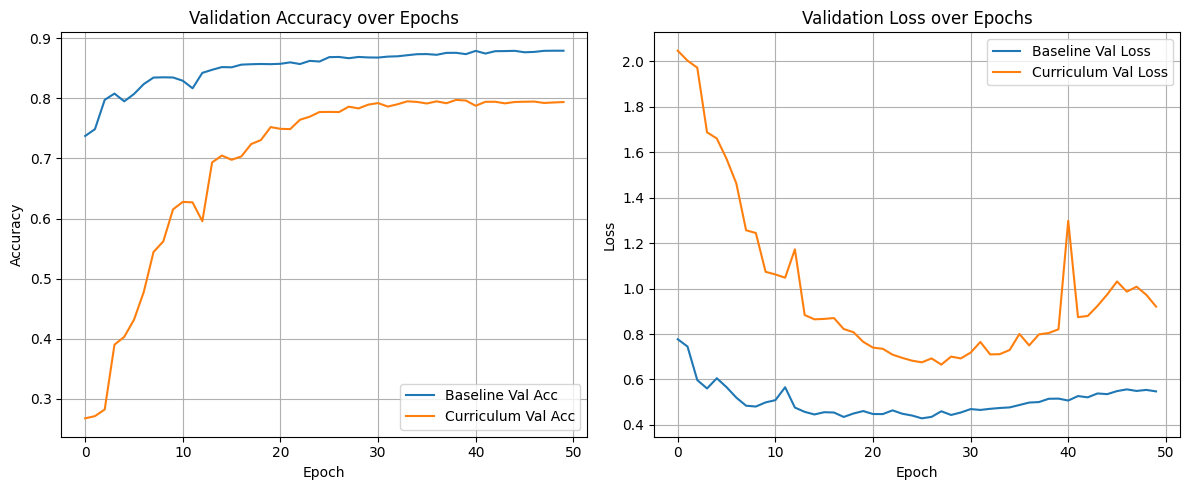

In [ ]:
# --- 6. Visualization of Results ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_baseline['val_acc'], label='Baseline Val Acc')
plt.plot(history_curriculum['val_acc'], label='Curriculum Val Acc')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_baseline['val_loss'], label='Baseline Val Loss')
plt.plot(history_curriculum['val_loss'], label='Curriculum Val Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()